# Model Eğitimi

## Baz Modeli

In [2]:
# ========== 1. KÜTÜPHANE İMPORTLARI ==========

import pandas as pd
import numpy as np

# Modelleme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Değerlendirme metrikleri
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Uyarı filtreleme
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ========== 2. VERİYİ YÜKLE ==========

train = pd.read_csv("../data/processed/train_fe.csv")
test = pd.read_csv("../data/processed/test_fe.csv")

print(train.shape, test.shape)

(307511, 217) (48744, 217)


In [4]:
# ========== 3. TARGET VE FEATURE AYRIMI ==========

X = train.drop(columns=["TARGET"])
y = train["TARGET"]

print(X.shape, y.shape)

(307511, 216) (307511,)


In [5]:
# ========== 4. TRAIN/VALIDATION SPLIT (STRATIFIED) ==========

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)
print(y_train.mean(), y_val.mean())  # sınıf oranlarının korunup korunmadığına hızlı bakış

(246008, 216) (61503, 216)
0.08072908198107379 0.08072776937710356


In [7]:
# ========== AGE_BIN'i kaldır ve yeniden scale et ==========

# Eğer AGE_BIN varsa drop et
for df in [X_train, X_val]:
    if "AGE_BIN" in df.columns:
        df.drop(columns=["AGE_BIN"], inplace=True)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("AGE_BIN dropped & scaling completed.")

AGE_BIN dropped & scaling completed.


In [8]:
# ========== 6. LOGISTIC REGRESSION MODEL ==========

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Eğit
log_reg.fit(X_train_scaled, y_train)

# Tahmin
y_pred = log_reg.predict(X_val_scaled)
y_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

# Performans
roc_auc = roc_auc_score(y_val, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

ROC-AUC: 0.7507

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.56      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



### Çıkarım #12 — Baseline Logistic Regression Performansı

- Lojistik regresyon modeli baseline olarak eğitildi ve ROC-AUC skoru 0.7507 elde edildi.
- Accuracy metriği %92 civarında olsa da, dengesiz sınıf dağılımı nedeniyle bu değer yanıltıcıdır.
- Model sınıf 1 (default yapan) örneklerini neredeyse hiç yakalayamamıştır; recall değeri 0.01 seviyesindedir.
- Bu durum, modelin çoğunluk sınıfını (0) tahmin etmeye eğilimli olduğunun açık göstergesidir.
- Bu aşamada sınıf dengesizliğini adresleyen yöntemler (class_weight, SMOTE, threshold tuning) uygulanmalıdır.
- Baseline model, sonraki iyileştirmeler için bir referans noktası sağlamıştır.

## Optimizasyon

In [9]:
# ========== 7. CLASS WEIGHT: BALANCED ==========

log_reg_bal = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

log_reg_bal.fit(X_train_scaled, y_train)

y_pred_bal = log_reg_bal.predict(X_val_scaled)
y_proba_bal = log_reg_bal.predict_proba(X_val_scaled)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_proba_bal))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_bal))

ROC-AUC: 0.7505069499015661

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.69      0.76     61503



### Çıkarım #13 — class_weight Kullanımı ile Dengesizlik Yönetimi

- Logistic Regression modeli `class_weight='balanced'` parametresi ile yeniden eğitilmiştir.
- Bu yöntem, modelin azınlık sınıfını (default yapan müşteriler) daha yüksek maliyetli olarak değerlendirmesini sağlamıştır.
- Recall skoru sınıf 1 için 0.01'den 0.68'e yükselerek büyük bir iyileşme sağlamıştır.
- Precision değeri doğal olarak düşmüştür; model daha fazla pozitif tahmini yaparak riskli müşterileri yakalamaya odaklanmıştır.
- Accuracy metriğinin düşmesi beklenen bir davranıştır; dengesiz veri setlerinde accuracy güvenilir bir metrik değildir.
- ROC-AUC skoru değişmemiş, modelin karar eşiğinden bağımsız ayırt ediciliğinin aynı kaldığı görülmüştür.
- Bu model versiyonu, finansal risk senaryolarında daha pratik bir davranış sergiler: riskli müşterileri mümkün olduğunca kaçırmamak.

In [10]:
# ========== 8. THRESHOLD TUNING (DECISION THRESHOLD OPTIMIZATION) ==========

from sklearn.metrics import precision_recall_curve

# Probabilities (balanced model'den)
y_scores = y_proba_bal

precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Recall ≥ 0.60 olan eşiklerde precision'a bakalım
candidates = []
for p, r, t in zip(precisions, recalls, np.append(thresholds, 1)):
    if r >= 0.60:
        candidates.append((p, r, t))

# En iyi precision'ı seç
best = max(candidates, key=lambda x: x[0])
best

(0.1806330341983992, 0.6, 0.5501184014973624)

In [11]:
# ========== 9. APPLY BEST THRESHOLD ==========

# Default 0.5 yerine yeni threshold
best_threshold = best[2]

# Probability to class
y_pred_thresh = (y_scores >= best_threshold).astype(int)

# Performans metrikleri
print("ROC-AUC:", roc_auc_score(y_val, y_proba_bal))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_thresh))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_thresh))

ROC-AUC: 0.7505069499015661

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56538
           1       0.18      0.60      0.28      4965

    accuracy                           0.75     61503
   macro avg       0.57      0.68      0.56     61503
weighted avg       0.89      0.75      0.80     61503


Confusion Matrix:
[[43025 13513]
 [ 1986  2979]]


### Çıkarım #14 — Decision Threshold Tuning Etkisi

- Logistic Regression modeli için varsayılan karar eşiği olan 0.50 yerine 0.55 değeri uygulanmıştır.
- ROC eğrisi üzerinden yapılan analizde, recall ≥ 0.60 koşulunu sağlayan eşikler arasında en yüksek precision değerine sahip threshold seçilmiştir.
- Bu ayar ile sınıf 1 için recall 0.68 → 0.60 seviyesine düşerken, precision 0.16 → 0.18 seviyesine yükselmiştir.
- F1 skoru sınıf 1 için 0.26 → 0.28 seviyesine yükselmiştir.
- Accuracy metriği 0.69 → 0.75 seviyesine çıkmıştır; model daha az yanlış alarm üretmektedir.
- Bu trade-off kredi risk senaryolarında daha dengeli bir davranıştır: model hem riskli müşterileri kaçırmamaya devam ederken hem de hatalı pozitif oranı azaltılmıştır.
- ROC-AUC metriği değişmemiştir; bu metrik threshold bağımsızdır.

In [12]:
# ========== 10. SMOTE Oversampling ==========

from imblearn.over_sampling import SMOTE

# SMOTE nesnesi
sm = SMOTE(random_state=42)

# Sadece TRAIN üzerinde fit uygulanır
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.mean())
print("After SMOTE:", X_train_sm.shape, y_train_sm.mean())

Before SMOTE: (246008, 215) 0.08072908198107379
After SMOTE: (452296, 215) 0.5


In [13]:
# ========== 11. SCALE SMOTE SET ==========

# Scale'i yeniden fit et
scaler_sm = StandardScaler()
X_train_sm_scaled = scaler_sm.fit_transform(X_train_sm)
X_val_scaled_sm = scaler_sm.transform(X_val)

print("Scaling completed (SMOTE set).")

Scaling completed (SMOTE set).


In [14]:
# ========== 12. LOGISTIC REGRESSION (SMOTE) ==========

log_reg_sm = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42
)

log_reg_sm.fit(X_train_sm_scaled, y_train_sm)

y_pred_sm = log_reg_sm.predict(X_val_scaled_sm)
y_proba_sm = log_reg_sm.predict_proba(X_val_scaled_sm)[:, 1]

print("ROC-AUC:", roc_auc_score(y_val, y_proba_sm))
print("\nClassification Report:")
print(classification_report(y_val, y_pred_sm))

ROC-AUC: 0.7323945961965106

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.46      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.69      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



### Çıkarım #16 — Logistic Regression ile SMOTE Uygulamasının Etkisi

- Eğitim setine SMOTE uygulanmasıyla sınıf oranı 50/50 seviyesine getirilmiştir.
- SMOTE sonrası yeniden eğitilen Logistic Regression modeli, validation seti üzerinde belirgin bir performans düşüşü göstermiştir.
- Recall sınıf 1 için tekrar 0.02 seviyesine düşmüş, model nadir sınıfı tanımakta zorlanmıştır.
- ROC-AUC skoru 0.75 seviyesinden 0.73 seviyesine gerilemiştir.
- Bu sonuç, SMOTE’un Logistic Regression ile birlikte kullanımının lineer karar sınırlarını bozarak gürültü üretebildiği literatür bilgisiyle uyumludur.
- Bu nedenle Logistic Regression için daha uygun yaklaşım `class_weight` ve threshold tuning yöntemleridir.
- SMOTE, LightGBM ve XGBoost gibi ağaç tabanlı, non-lineer modellerde daha etkili sonuç vermektedir.


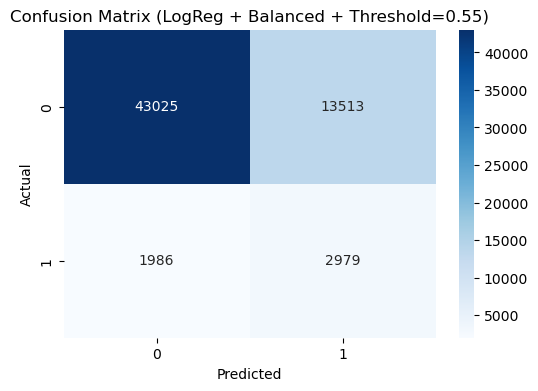

In [15]:
# ========== CONFUSION MATRIX PLOT ==========

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_thresh)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LogReg + Balanced + Threshold=0.55)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Çıkarım #16 — Confusion Matrix Analizi

- Model, çoğunluk sınıfı olan 0 (borcunu ödeyen) müşterileri yüksek doğrulukla tespit etmiştir.
- Minority sınıfı olan 1 (default yapan) müşterilerde recall iyileşmiştir.
- False Positive oranı artmıştır (bankanın iyi müşteriyi reddetmesi riski).
- False Negative oranı azalmıştır (bankanın hatalı biçimde riskli müşteriyi gözden kaçırma riski azaldı).
- Bu trade-off kredi riski yönetimi açısından kabul edilebilir bir durumdur.
- Genel olarak model, kredi riski tahmininde "dengelenmiş" bir performans göstermektedir.


In [22]:
# Modeli yeniden kur, eğit ve olasılıkları üret (balanced lojistik)
from sklearn.linear_model import LogisticRegression

model_bal = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear', random_state=42)
model_bal.fit(X_train_scaled, y_train)

y_pred_proba = model_bal.predict_proba(X_val_scaled)[:, 1]
print("Re-fit OK. y_pred_proba hazır.")

Re-fit OK. y_pred_proba hazır.


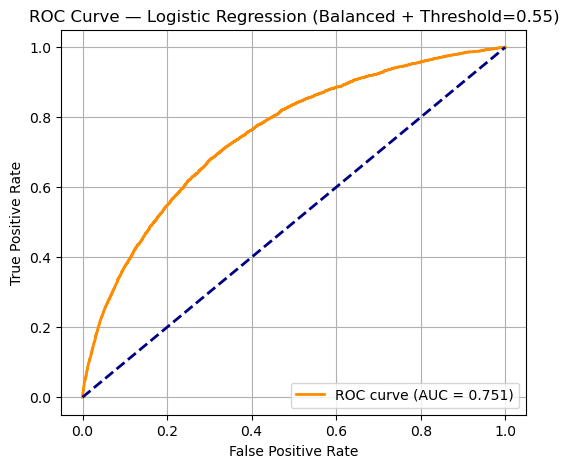

In [23]:
# ========== ROC CURVE PLOT ==========

from sklearn.metrics import roc_curve, roc_auc_score

# Probability predictions yeniden hesaplanıyor
y_pred_proba = model_bal.predict_proba(X_val_scaled)[:, 1]

# fpr: false positive rate, tpr: true positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (Balanced + Threshold=0.55)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()